In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf


KeyboardInterrupt: 

In [ ]:
def import_data():

    ds_train,info = tfds.load('caltech_birds2010', split='train',with_info=True)
    ds_test,info = tfds.load('caltech_birds2010', split='test',with_info=True)
    
    return ds_train,ds_test,info

In [ ]:
ds_train_raw,ds_test_raw,info = import_data()

In [ ]:
IMAGE_SIZE = 128
def pre_process_image(record):
    
    image = record["image"]
    image = image / 255
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32)
    
    seg_image = record["segmentation_mask"]
    seg_image = tf.image.resize(seg_image, (IMAGE_SIZE, IMAGE_SIZE))
    seg_image = tf.cast(seg_image, tf.float32)
    return image,seg_image

resize_train = ds_train_raw.map(pre_process_image)

resize_test = ds_test_raw.map(pre_process_image)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image =  next(iter(resize_test.shuffle(100).take(1)))
mask = np.repeat(image[1],3).reshape(IMAGE_SIZE,IMAGE_SIZE,3)

plt.imshow(np.hstack([image[0],mask]))
# display that image
plt.show()

In [23]:
from tensorflow import keras

layer_repeat = 2
filters_collection = [16,32,64,128]

inputs = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3),name="image")

conv1 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
conv1 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv1)
pool1 = keras.layers.MaxPooling2D(2)(conv1)

conv2 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(pool1)
conv2 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv2)
pool2 = keras.layers.MaxPooling2D(2)(conv2)

conv3 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(pool2)
conv3 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)
pool3 = keras.layers.MaxPooling2D(2)(conv3)

conv4 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool3)
conv4 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
pool4 = keras.layers.MaxPooling2D(2)(conv4)

conv5 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool4)
conv5 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
pool4 = keras.layers.MaxPooling2D(2)(conv5)

convT1 = keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)

skip1 = keras.layers.concatenate([convT1, conv4])
conv6 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(skip1)
conv6 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv6)
convT2 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv6)

skip2 = keras.layers.concatenate([convT2, conv3])
conv7 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(skip2)
conv7 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv7)
convT3 = keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv7)

skip3 = keras.layers.concatenate([convT3, conv2])
conv8 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(skip3)
conv8 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv8)
convT4 = keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv8)


skip4 = keras.layers.concatenate([convT4, conv1])
conv9 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(skip4)
conv10 = keras.layers.Conv2D(16, (1,1), strides=(1,1), padding='same', name = "c10")(conv9)

In [24]:
outputs = keras.layers.Conv2D(1, (1,1), activation="sigmoid", padding="same")(conv10)
model = keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [11]:
import tensorflow.keras as K
def dice_coef(y_true, y_pred):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)

    return (2. * intersection) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f))

def diceCoefLoss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

In [12]:
ds_train = resize_train.batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = resize_test.batch(128).prefetch(tf.data.AUTOTUNE)

In [15]:
model.load_weights("bird_segmentation.h5")

In [18]:
model.compile(optimizer=K.optimizers.RMSprop(learning_rate=0.0001), loss=diceCoefLoss, metrics = ['Accuracy', 'Precision', 'Recall', 'AUC',K.metrics.MeanIoU(num_classes=2),dice_coef])

callbacks = [
    K.callbacks.ModelCheckpoint("../Segmenatation/bird_segmentation.h5", save_best_only=True, monitor="val_auc",mode="max")
]

# Train the model, doing validation at the end of each epoch.
epochs = 20


In [19]:
history = model.fit(ds_train,validation_data=ds_test,epochs=epochs,verbose=2,callbacks=callbacks)

Epoch 1/20
24/24 - 662s - loss: 0.2438 - Accuracy: 0.9125 - precision: 0.7499 - recall: 0.7674 - auc: 0.8683 - val_loss: 0.2840 - val_Accuracy: 0.8884 - val_precision: 0.6231 - val_recall: 0.8551 - val_auc: 0.8896 - 662s/epoch - 28s/step
Epoch 2/20
24/24 - 616s - loss: 0.2219 - Accuracy: 0.9198 - precision: 0.7694 - recall: 0.7911 - auc: 0.8834 - val_loss: 0.2695 - val_Accuracy: 0.9020 - val_precision: 0.6763 - val_recall: 0.8021 - val_auc: 0.8737 - 616s/epoch - 26s/step
Epoch 3/20
24/24 - 639s - loss: 0.2258 - Accuracy: 0.9185 - precision: 0.7652 - recall: 0.7882 - auc: 0.8808 - val_loss: 0.2550 - val_Accuracy: 0.9169 - val_precision: 0.7663 - val_recall: 0.7273 - val_auc: 0.8545 - 639s/epoch - 27s/step
Epoch 4/20
24/24 - 619s - loss: 0.2192 - Accuracy: 0.9211 - precision: 0.7751 - recall: 0.7903 - auc: 0.8830 - val_loss: 0.2560 - val_Accuracy: 0.9174 - val_precision: 0.7729 - val_recall: 0.7186 - val_auc: 0.8515 - 619s/epoch - 26s/step
Epoch 5/20
24/24 - 623s - loss: 0.2197 - Accurac

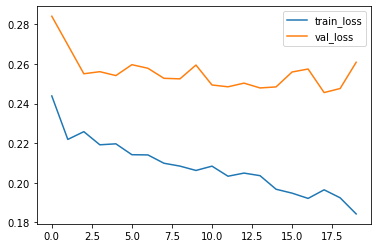

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"],label= "train_loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()

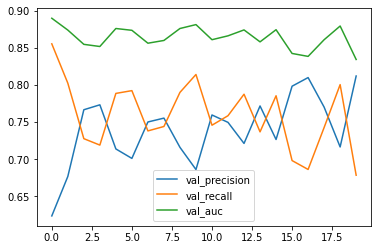

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history["val_precision"],label= "val_precision")
plt.plot(history.history["val_recall"],label="val_recall")
plt.plot(history.history["val_auc"],label="val_auc")
plt.plot()
plt.legend()

In [27]:
from keras.models import load_model

In [28]:
loaded = load_model("bird_segmentation.h5",compile=False)

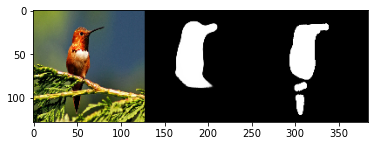

In [70]:
image = next(iter(resize_test.shuffle(100).take(1)))
import cv2
import numpy as np
import matplotlib.pyplot as plt
mask = np.repeat(image[1],3).reshape(IMAGE_SIZE,IMAGE_SIZE,3)
pred = np.repeat(loaded.predict(image[0].numpy().reshape(-1,128,128,3))[0],3).reshape((IMAGE_SIZE,IMAGE_SIZE,3))
plt.imshow(np.hstack([image[0],pred,mask]))

# display that image
plt.show()